In [1]:
%cd ..

/home/akajal/DiVAE


In [2]:
# Python imports
import os
import sys

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if par_dir not in sys.path:
    sys.path.append(par_dir)
    
# ML imports
import torch
import matplotlib.pyplot as plt
import numpy as np

# DiVAE imports
from models.rbm.chimeraRBM import ChimeraRBM
from models.rbm.rbm import RBM
from models.samplers.pcd import PCD

from utils import *

# DWave imports
from dwave.system import DWaveSampler, LeapHybridSampler
import neal

[13:40:26.053] INFO   DiVAE                                             Willkommen!
[13:40:26.055] INFO   DiVAE                                             Loading configuration.
2022-02-25 13:40:28,730 dwave.cloud INFO  MainThread Log level for 'dwave.cloud' namespace set to 0
[13:40:28.730] INFO   dwave.cloud                                       Log level for 'dwave.cloud' namespace set to 0


In [3]:
_NUM_NODES = 16
crbm = ChimeraRBM(n_visible=_NUM_NODES, n_hidden=_NUM_NODES)
crbm_sampler = PCD(batch_size=1024, RBM=crbm, n_gibbs_sampling_steps=100)

In [4]:
crbm_vis, crbm_hid = crbm_sampler.block_gibbs_sampling()

In [5]:
crbm = crbm_sampler.get_rbm()
crbm_weights, crbm_vbias, crbm_hbias = crbm.weights, crbm.visible_bias, crbm.hidden_bias

In [87]:
crbm_energies = sample_energies(crbm, crbm_vis, crbm_hid).detach().cpu().numpy()

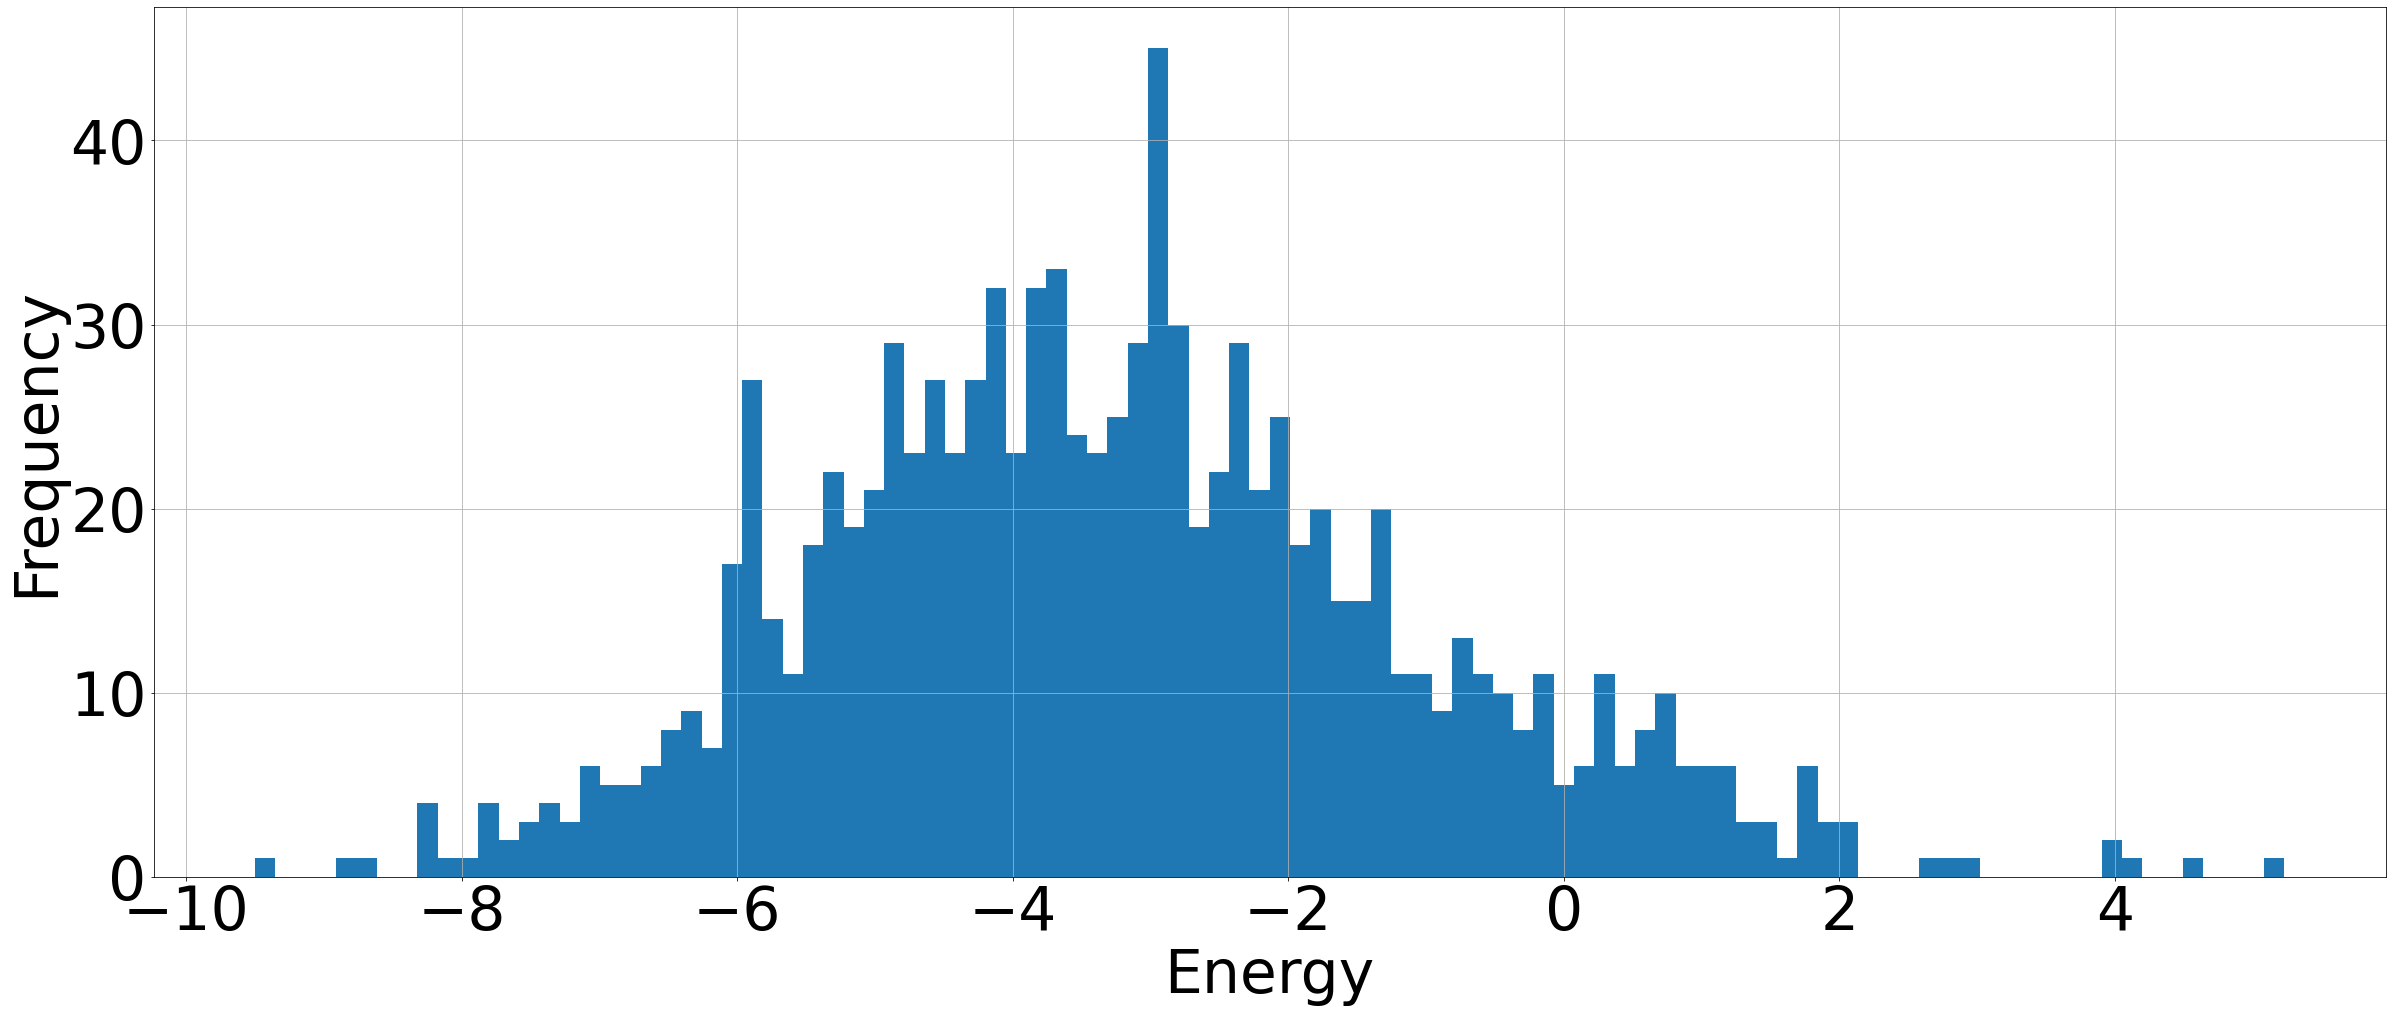

In [88]:
plot_sample_energies(crbm_energies)

In [41]:
ising_weights = crbm_weights/4.
ising_vbias = crbm_vbias/2. + torch.sum(crbm_weights, dim=1)/4.
ising_hbias = crbm_hbias/2. + torch.sum(crbm_weights, dim=0)/4.

In [55]:
a = torch.randn(2,3)
a

tensor([[ 0.4420,  0.8894, -1.2825],
        [ 0.6543,  2.2991, -1.8567]])

In [56]:
a[0, 0]

tensor(0.4420)

In [57]:
a[0, 1]

tensor(0.8894)

In [61]:
a.sum(0)

tensor([ 1.0963,  3.1884, -3.1392])

In [62]:
a.sum(1)

tensor([0.0488, 1.0967])

In [65]:
torch.sum(a, dim=0, keepdim=True)

tensor([[ 1.0963,  3.1884, -3.1392]])

In [66]:
torch.sum(a, dim=0, keepdim=True).size()

torch.Size([1, 3])

In [60]:
torch.sum(a, dim=1, keepdim=True)
torch.sum(a, dim=1, keepdim=True).size()

torch.Size([2, 1])

In [42]:
zero = torch.tensor(0., dtype=torch.float)
minus_one = torch.tensor(-1., dtype=torch.float)

ising_vis = torch.where(crbm_vis == zero, minus_one, crbm_vis)
ising_hid = torch.where(crbm_hid == zero, minus_one, crbm_hid)

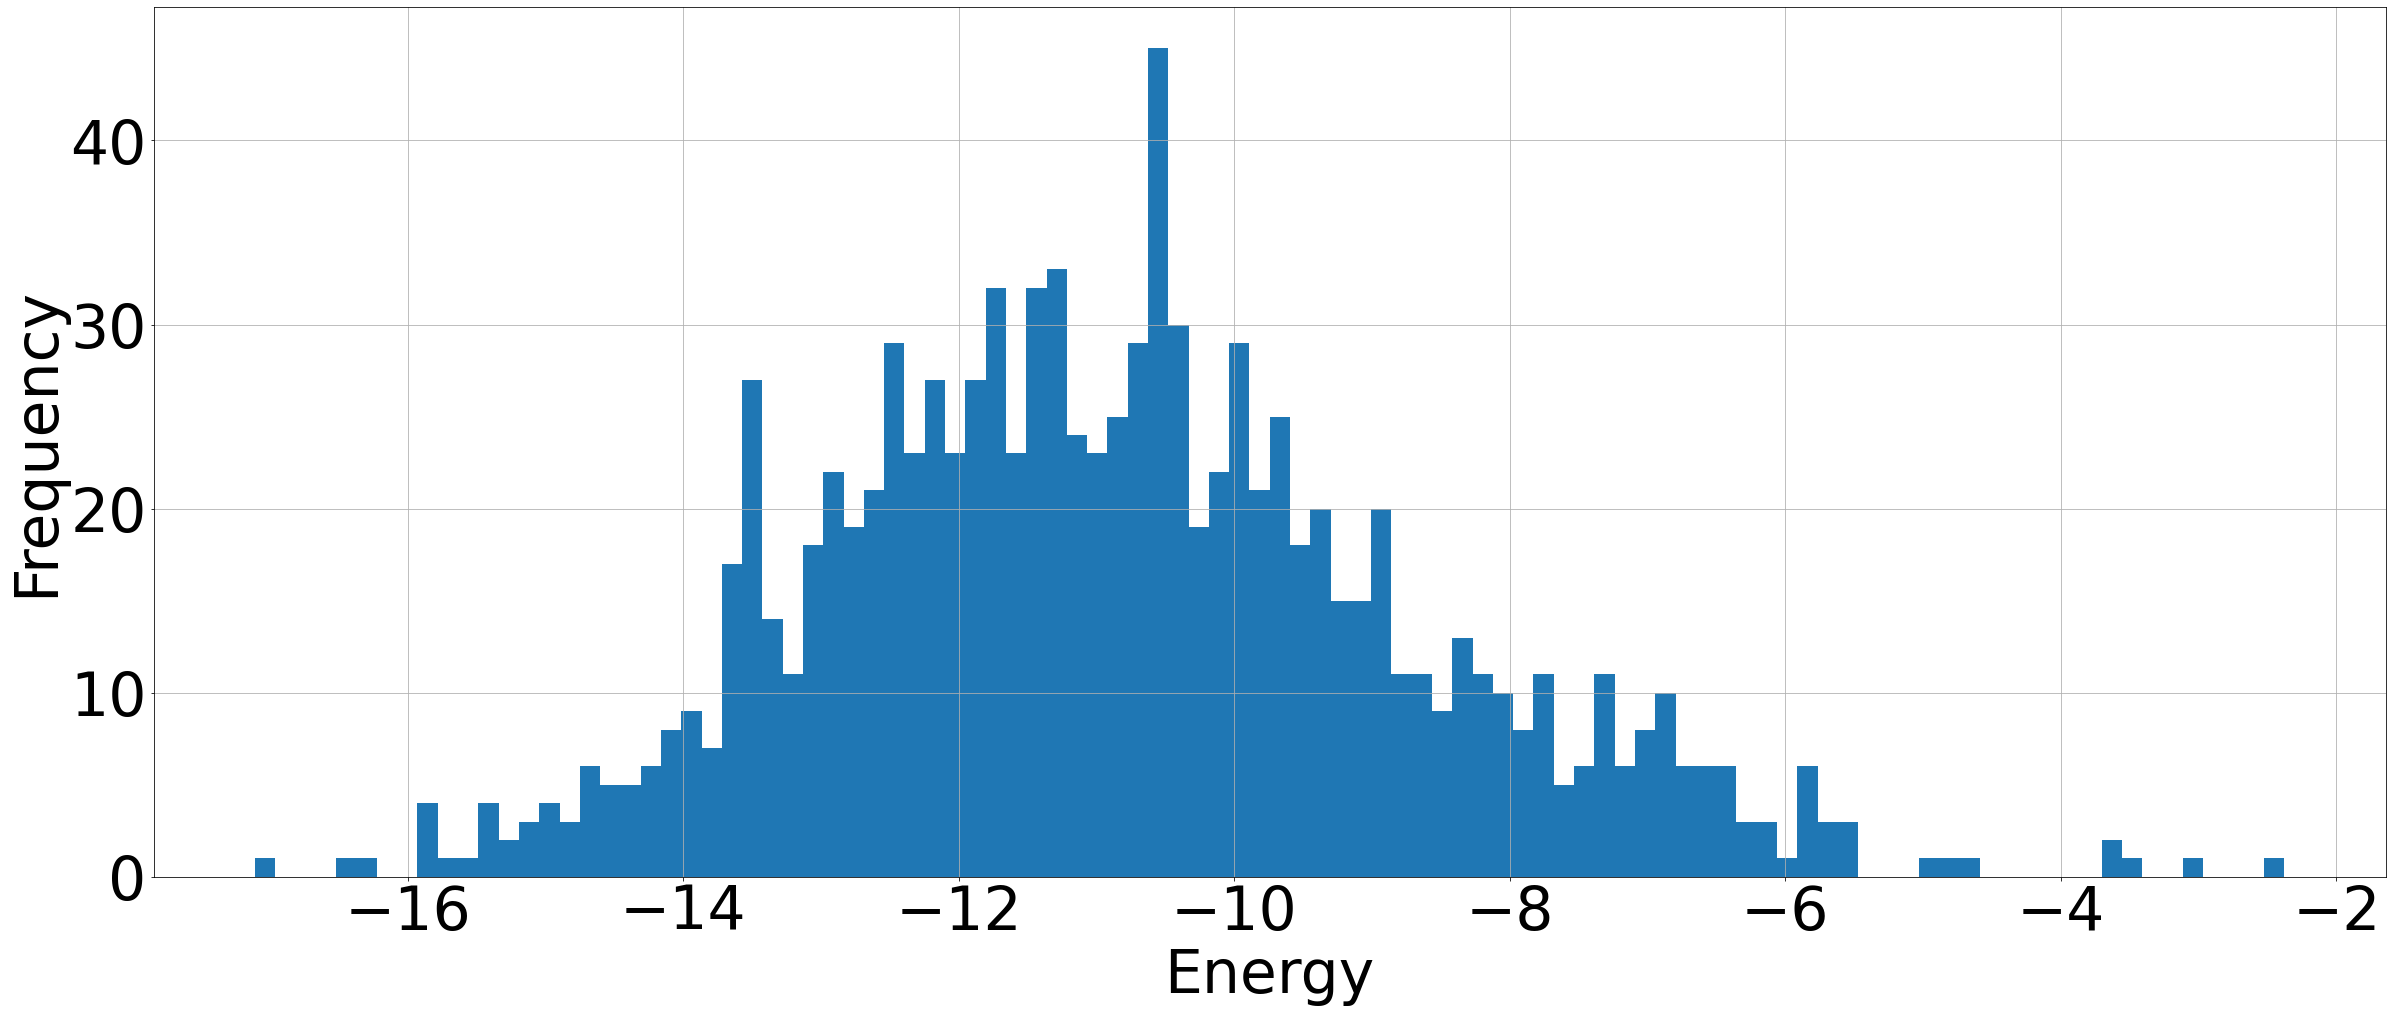

In [89]:
ising_energies = sample_energies_exp(ising_weights, ising_vbias, ising_hbias, ising_vis, ising_hid).detach().cpu().numpy()
plot_sample_energies(ising_energies)

In [74]:
def sample_energies_exp_ising(rbm_weights, rbm_visible_bias, rbm_hidden_bias, 
                              ising_weights, ising_visible_bias, ising_hidden_bias,
                              rbm_vis, rbm_hid):
    """
    Compute the energies of samples produced by the RBM transformed into Ising samples

    Returns:
        rbm_energy_exp : -vis^T W hid - a^T hid - b^T vis + K
    """
    # Broadcast W to (pcd_batchSize * nVis * nHid)
    w, vbias, hbias = ising_weights, ising_visible_bias, ising_hidden_bias
    
    w_sum = torch.sum(rbm_weights)
    vbias_sum = torch.sum(rbm_visible_bias)
    hbias_sum = torch.sum(rbm_hidden_bias)
    
    print(w_sum, vbias_sum, hbias_sum)
    
    ising_offset = (w_sum/2. + vbias_sum + hbias_sum)/2.
    print(ising_offset)
    
    w = w + torch.zeros((rbm_vis.size(0),) + w.size(), device=rbm_vis.device)
    vbias = vbias.to(rbm_vis.device)
    hbias = hbias.to(rbm_hid.device)

    # Prepare H, V for torch.matmul()
    # Change V.size() from (batchSize * nVis) to (batchSize * 1 * nVis)
    vis = rbm_vis.unsqueeze(2).permute(0, 2, 1)
    # Change H.size() from (batchSize * nHid) to (batchSize * nHid * 1)
    hid = rbm_hid.unsqueeze(2)

    batch_energies = (- torch.matmul(vis, torch.matmul(w, hid)).reshape(-1) 
                      - torch.matmul(rbm_vis, vbias)
                      - torch.matmul(rbm_hid, hbias))
    batch_energies_shifted = batch_energies - ising_offset
    return batch_energies_shifted

In [90]:
ising_energies = sample_energies_exp_ising(crbm_weights, crbm_vbias, crbm_hbias,
                                           ising_weights, ising_vbias, ising_hbias, 
                                           ising_vis, ising_hid).detach().cpu().numpy()

tensor(-46.4277, grad_fn=<SumBackward0>) tensor(8., grad_fn=<SumBackward0>) tensor(0., grad_fn=<SumBackward0>)
tensor(-7.6069, grad_fn=<DivBackward0>)


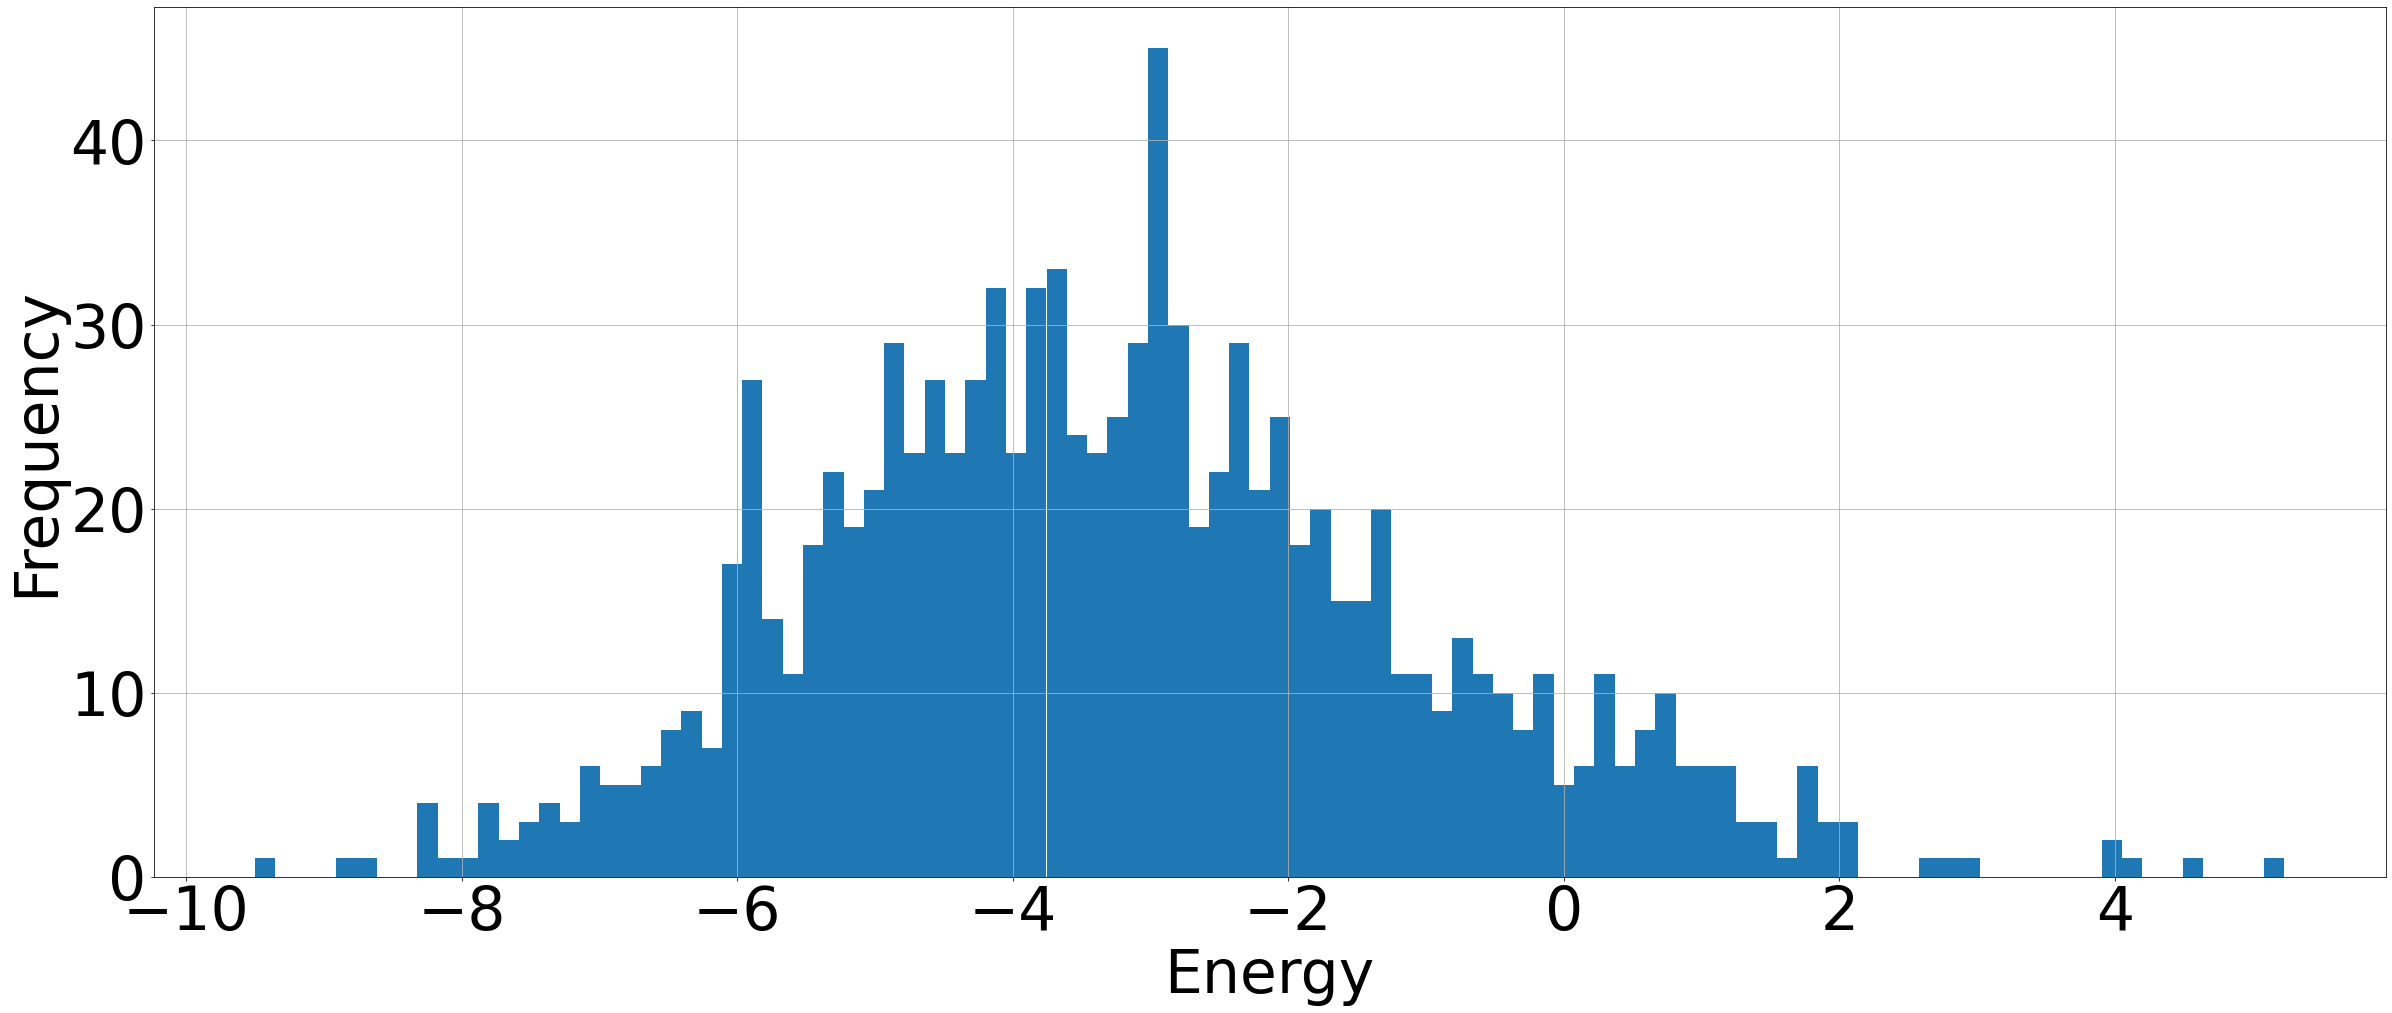

In [91]:
plot_sample_energies(ising_energies)

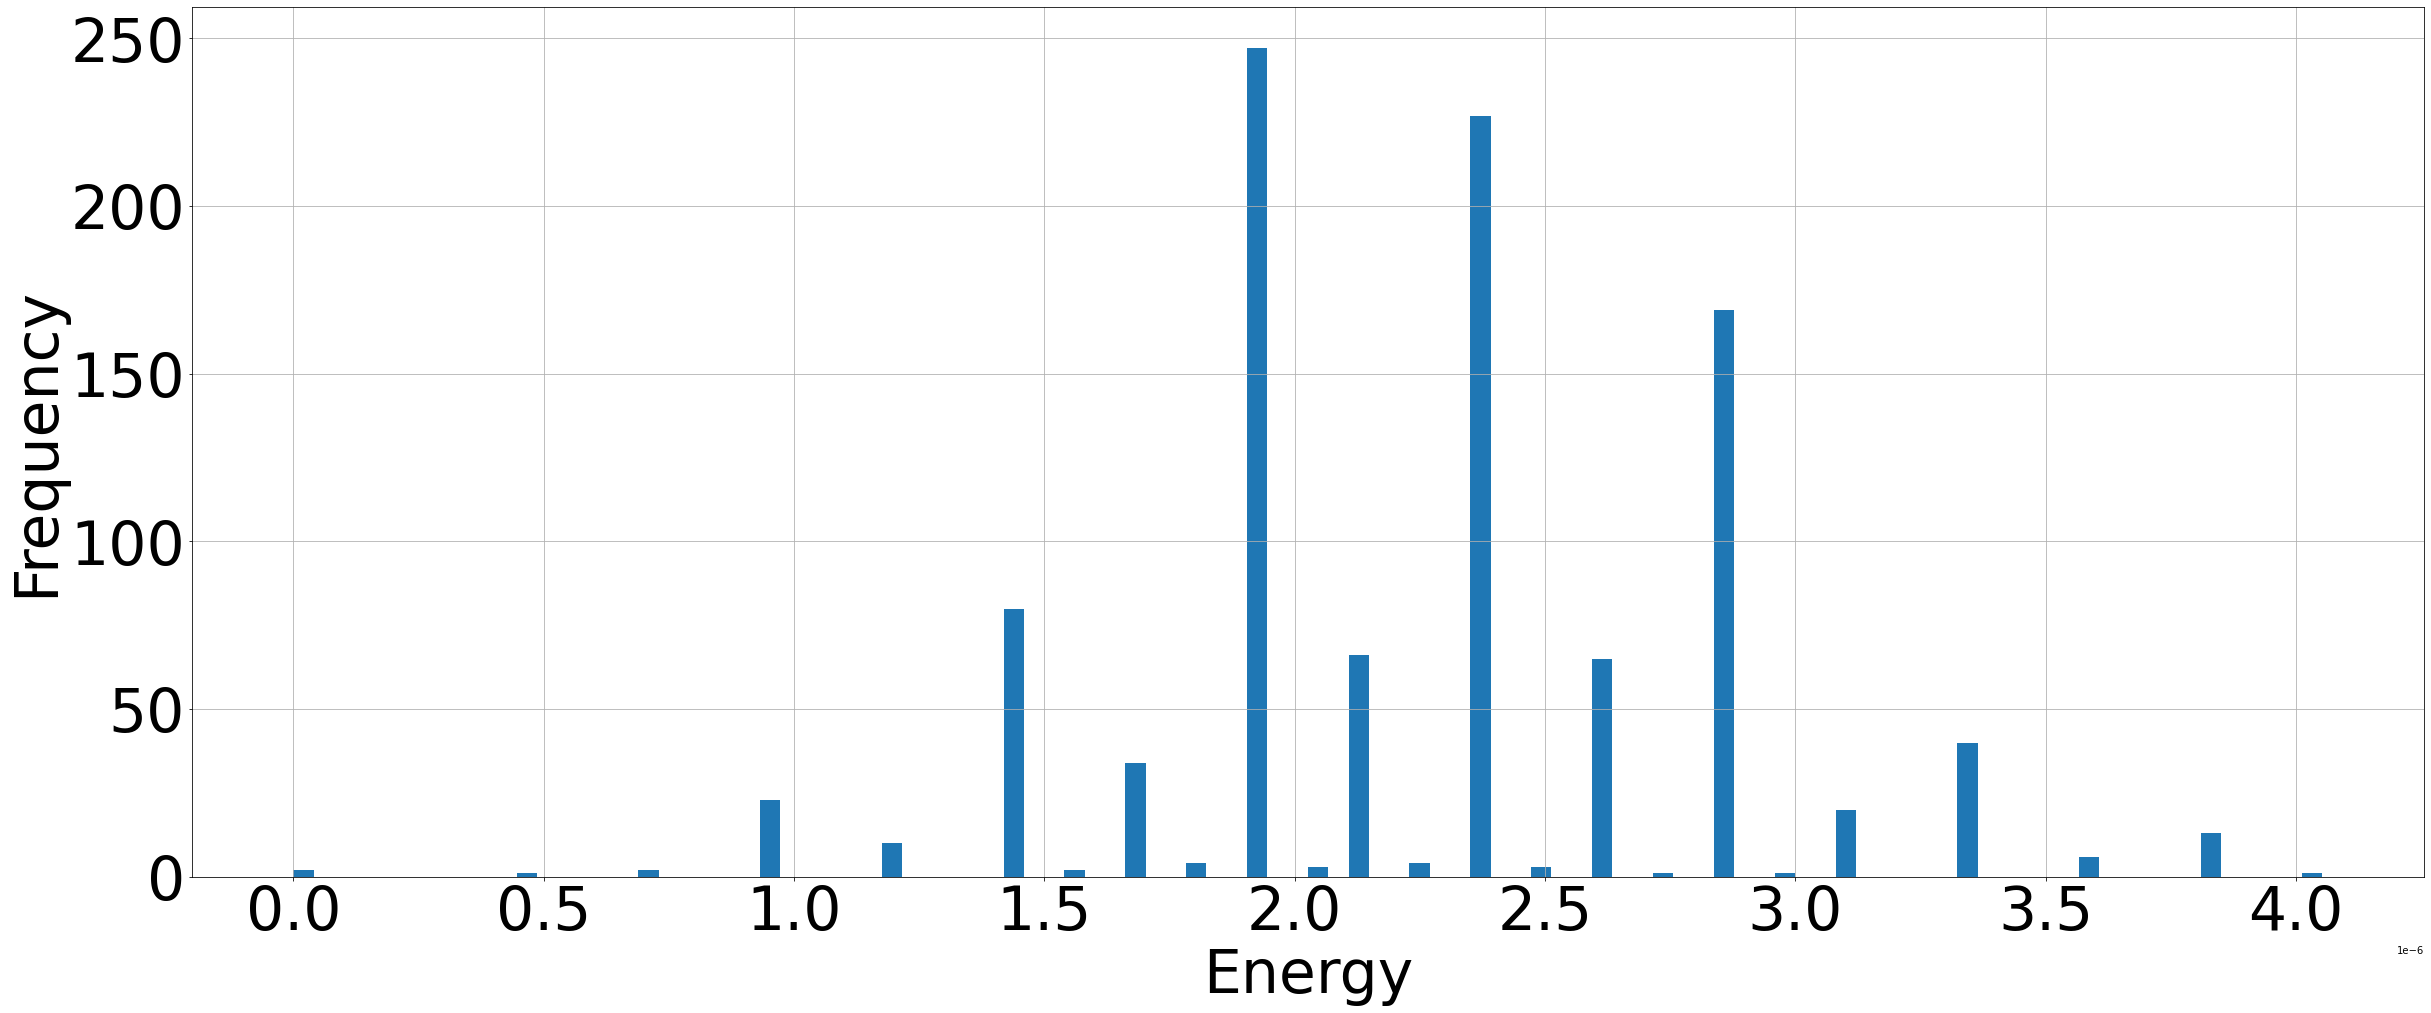

In [92]:
plot_sample_energies((crbm_energies - ising_energies))

In [79]:
crbm_energies

array([ 1.7673874, -1.4363639, -2.8950393, ..., -2.3338842, -1.5400889,
       -5.8758645], dtype=float32)

In [80]:
ising_energies

array([ 1.7673845, -1.4363661, -2.8950424, ..., -2.333887 , -1.5400915,
       -5.875867 ], dtype=float32)

In [81]:
diff = crbm_energies - ising_energies

In [82]:
diff

array([2.8610229e-06, 2.1457672e-06, 3.0994415e-06, ..., 2.8610229e-06,
       2.6226044e-06, 2.3841858e-06], dtype=float32)

In [85]:
diff[diff > 1e-5]

array([], dtype=float32)